# Project Overview

This project focuses on forecasting PM2.5 air pollution levels in Beijing using advanced time series analysis and deep learning techniques. Leveraging the Beijing PM2.5 dataset from the UCI Machine Learning Repository, the workflow encompasses comprehensive data preprocessing, exploratory analysis, and the development of a Long Short-Term Memory (LSTM) neural network for accurate prediction.

## Key Steps and Highlights

- **Data Acquisition & Cleaning:**  
    The dataset is loaded and cleaned by handling missing values, removing outliers, and resampling to ensure consistent hourly intervals.

- **Feature Engineering:**  
    Lag features and rolling averages are created to capture temporal dependencies and smooth out short-term fluctuations.

- **Exploratory Data Analysis:**  
    Visualizations such as boxplots, time series plots, and rolling means provide insights into data distribution, trends, and seasonality.

- **Data Preparation:**  
    The data is normalized and structured into sequences suitable for LSTM input, with careful train-test splitting to preserve chronological order.

- **Model Development:**  
    An LSTM model is built and trained with early stopping to prevent overfitting. Baseline models are also evaluated for comparison.

- **Evaluation & Visualization:**  
    Model performance is assessed using Mean Absolute Error (MAE), and predictions are visualized alongside actual values to demonstrate forecasting accuracy.



---

In [1]:

# Import libraries 
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
# fetch the dataset
dt = fetch_ucirepo(
    id=381,
)

# Extract the features and target variable
X = dt.data.features
y = dt.data.targets

# combine the features and target into a single DataFrame
df = pd.concat([X, y], axis=1)
# view the first few rows of the DataFrame
print(df.head())

   year  month  day  hour  DEWP  TEMP    PRES cbwd    Iws  Is  Ir  pm2.5
0  2010      1    1     0   -21 -11.0  1021.0   NW   1.79   0   0    NaN
1  2010      1    1     1   -21 -12.0  1020.0   NW   4.92   0   0    NaN
2  2010      1    1     2   -21 -11.0  1019.0   NW   6.71   0   0    NaN
3  2010      1    1     3   -21 -14.0  1019.0   NW   9.84   0   0    NaN
4  2010      1    1     4   -20 -12.0  1018.0   NW  12.97   0   0    NaN


### Data Preprocessing

In [3]:
# create the datetie index
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
# set the datetime as the index
df.set_index("datetime", inplace=True)

# drop the original date columns
df.drop(columns=["year", "month", "day", "hour"], inplace=True)

# sort by timestamp
df.sort_index(inplace=True)



In [4]:
#display the first few rows
print(df.head(15))

                     DEWP  TEMP    PRES cbwd    Iws  Is  Ir  pm2.5
datetime                                                          
2010-01-01 00:00:00   -21 -11.0  1021.0   NW   1.79   0   0    NaN
2010-01-01 01:00:00   -21 -12.0  1020.0   NW   4.92   0   0    NaN
2010-01-01 02:00:00   -21 -11.0  1019.0   NW   6.71   0   0    NaN
2010-01-01 03:00:00   -21 -14.0  1019.0   NW   9.84   0   0    NaN
2010-01-01 04:00:00   -20 -12.0  1018.0   NW  12.97   0   0    NaN
2010-01-01 05:00:00   -19 -10.0  1017.0   NW  16.10   0   0    NaN
2010-01-01 06:00:00   -19  -9.0  1017.0   NW  19.23   0   0    NaN
2010-01-01 07:00:00   -19  -9.0  1017.0   NW  21.02   0   0    NaN
2010-01-01 08:00:00   -19  -9.0  1017.0   NW  24.15   0   0    NaN
2010-01-01 09:00:00   -20  -8.0  1017.0   NW  27.28   0   0    NaN
2010-01-01 10:00:00   -19  -7.0  1017.0   NW  31.30   0   0    NaN
2010-01-01 11:00:00   -18  -5.0  1017.0   NW  34.43   0   0    NaN
2010-01-01 12:00:00   -19  -5.0  1015.0   NW  37.56   0   0   

In [5]:
# Convert the datetime index from Africa/Lagos to Asia/Shanghai (Beijing time)
df.index = df.index.tz_localize('Asia/Shanghai')
print(df.head())

                           DEWP  TEMP    PRES cbwd    Iws  Is  Ir  pm2.5
datetime                                                                
2010-01-01 00:00:00+08:00   -21 -11.0  1021.0   NW   1.79   0   0    NaN
2010-01-01 01:00:00+08:00   -21 -12.0  1020.0   NW   4.92   0   0    NaN
2010-01-01 02:00:00+08:00   -21 -11.0  1019.0   NW   6.71   0   0    NaN
2010-01-01 03:00:00+08:00   -21 -14.0  1019.0   NW   9.84   0   0    NaN
2010-01-01 04:00:00+08:00   -20 -12.0  1018.0   NW  12.97   0   0    NaN


### Exploratory Data Analysis

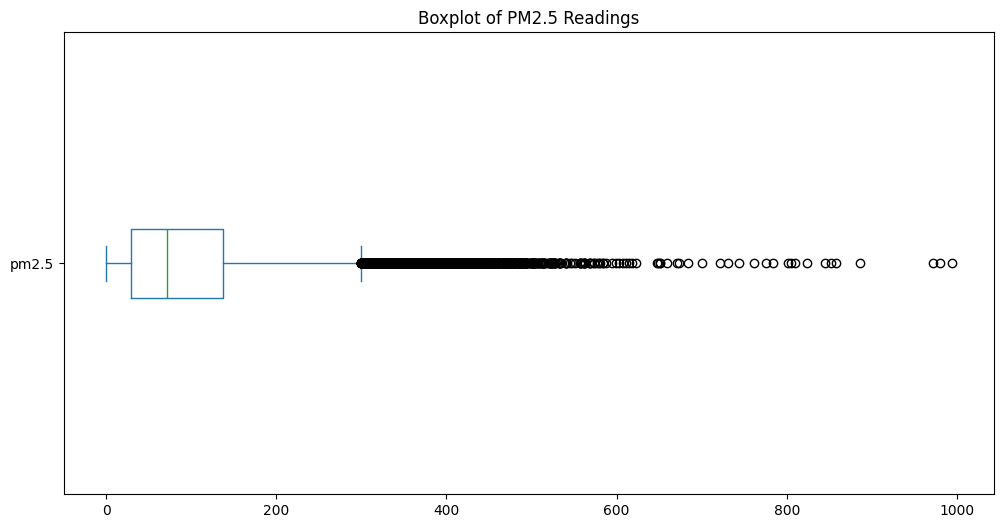

In [6]:
# create boxplot of "pm2.5" readings using pandas
fig, ax = plt.subplots(figsize=(12, 6))
df["pm2.5"].plot(kind='box', ax=ax, vert=False, title='Boxplot of PM2.5 Readings')
plt.show()

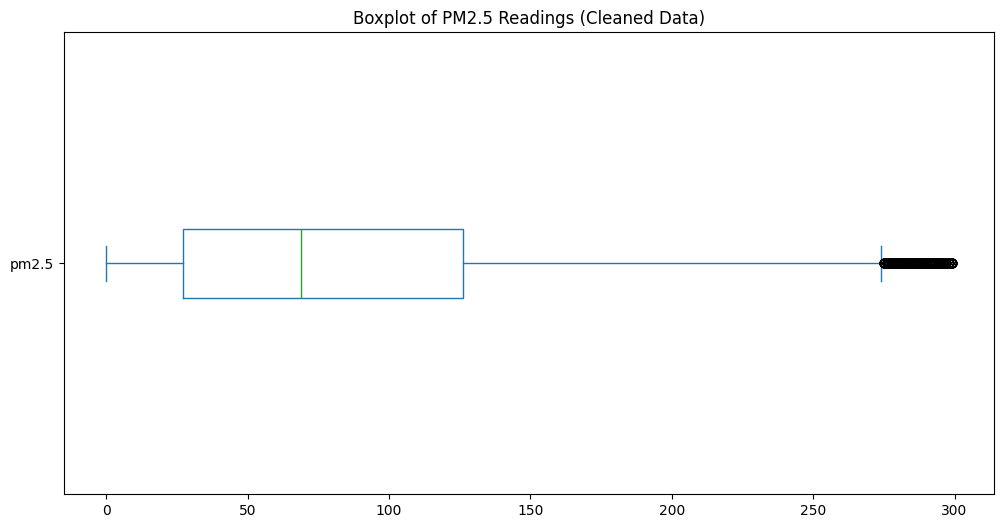

In [7]:
# drop outliers based on the boxplot
q1 = df["pm2.5"].quantile(0.25)
q3 = df["pm2.5"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_new = df[(df["pm2.5"] >= lower_bound) & (df["pm2.5"] <= upper_bound)]
#  boxplot of the cleaned data
fig, ax = plt.subplots(figsize=(12, 6))
df_new["pm2.5"].plot(kind='box', ax=ax, vert=False, title='Boxplot of PM2.5 Readings (Cleaned Data)')
plt.show()

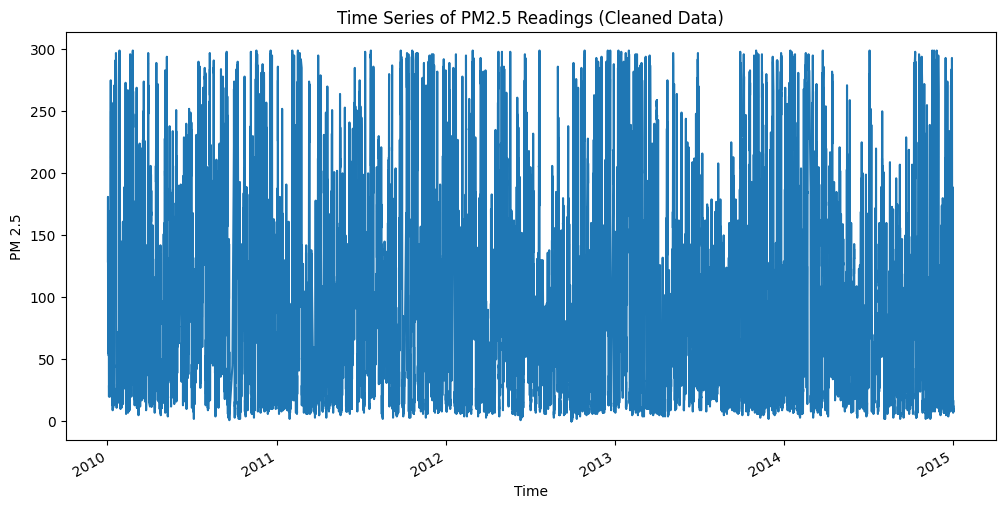

In [8]:
# check time series of cleaned data
fig, ax = plt.subplots(figsize=(12, 6))
df_new["pm2.5"].plot(xlabel='Time', ylabel='PM 2.5', title='Time Series of PM2.5 Readings (Cleaned Data)', ax=ax);

## Resampling Data to Hourly Frequency (1H)

In this section, we will resample the data to an hourly frequency (`1H`) to ensure consistent time intervals for further analysis assnd to create a good predictive model

In [10]:
# resample for 1H 
df_new["pm2.5"].resample('1h').mean().head()

datetime
2010-01-02 00:00:00+08:00    129.0
2010-01-02 01:00:00+08:00    148.0
2010-01-02 02:00:00+08:00    159.0
2010-01-02 03:00:00+08:00    181.0
2010-01-02 04:00:00+08:00    138.0
Freq: h, Name: pm2.5, dtype: float64

In [11]:
# check if we still have null values
df_new["pm2.5"].resample('1h').mean().isnull().sum()

np.int64(3816)

In [12]:
# cforward fill the missing values
df_new["pm2.5"].resample('1h').mean().fillna(method='ffill').head()

C:\Users\User\AppData\Local\Temp\ipykernel_18852\3551900461.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new["pm2.5"].resample('1h').mean().fillna(method='ffill').head()


datetime
2010-01-02 00:00:00+08:00    129.0
2010-01-02 01:00:00+08:00    148.0
2010-01-02 02:00:00+08:00    159.0
2010-01-02 03:00:00+08:00    181.0
2010-01-02 04:00:00+08:00    138.0
Freq: h, Name: pm2.5, dtype: float64

In [13]:
# confirm the null values again
df_new["pm2.5"].resample('1h').mean().fillna(method='ffill').to_frame().head().isnull().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_18852\1918100715.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new["pm2.5"].resample('1h').mean().fillna(method='ffill').to_frame().head().isnull().sum()


pm2.5    0
dtype: int64

In [14]:
# return to dataframe 
# resample the data to 1 hour and fill missing values
df_new["pm2.5"].resample('1h').mean().fillna(method='ffill').to_frame().head()

C:\Users\User\AppData\Local\Temp\ipykernel_18852\2930055024.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_new["pm2.5"].resample('1h').mean().fillna(method='ffill').to_frame().head()


,pm2.5
datetime,
2010-01-02 00:00:00+08:00,129.0
2010-01-02 01:00:00+08:00,148.0
2010-01-02 02:00:00+08:00,159.0
2010-01-02 03:00:00+08:00,181.0
2010-01-02 04:00:00+08:00,138.0


In [15]:
df_new.shape

(39984, 8)

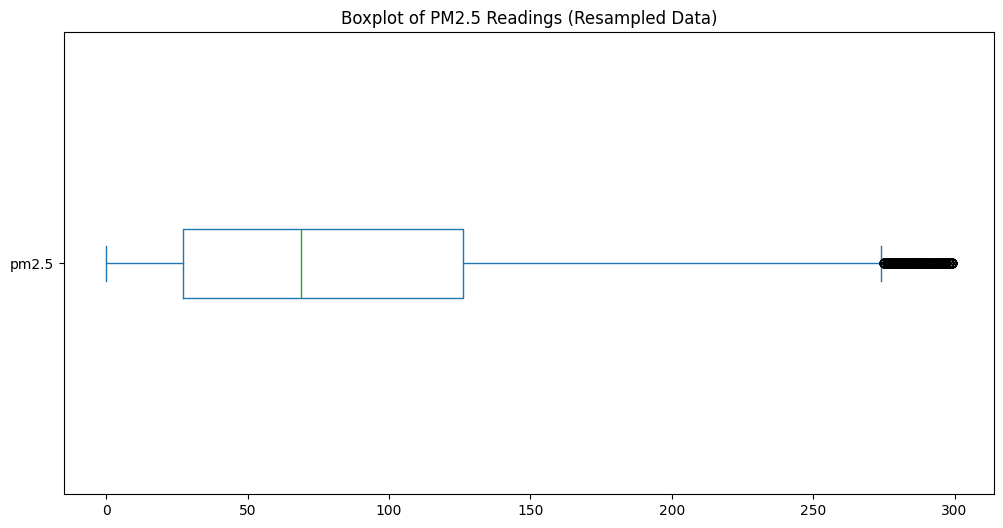

In [16]:
# recheck for outliers again
fig, ax = plt.subplots(figsize=(12, 6))
df_new["pm2.5"].plot(kind="box", vert=False, ax=ax, title='Boxplot of PM2.5 Readings (Resampled Data)');

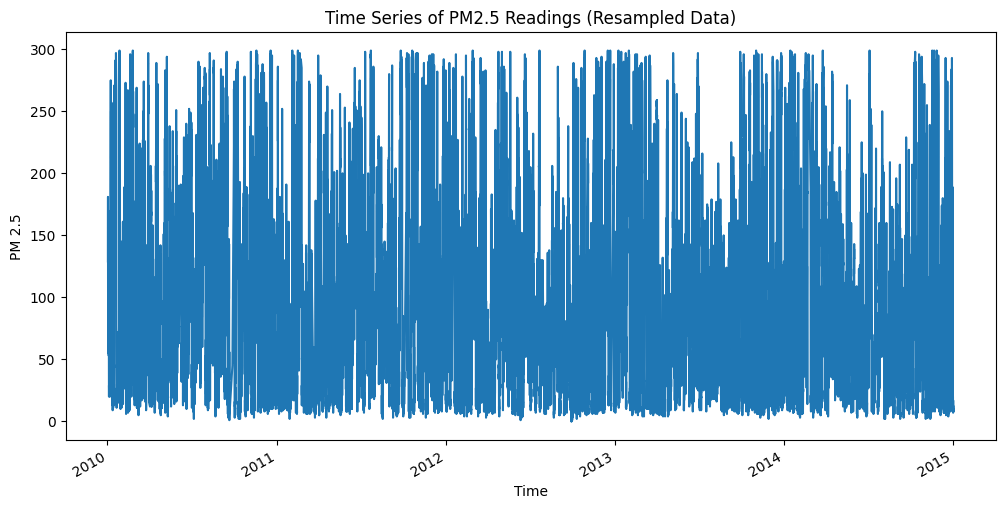

In [17]:
# check the time series again
fig, ax = plt.subplots(figsize=(12, 6))
df_new["pm2.5"].plot(xlabel='Time', ylabel='PM 2.5', title='Time Series of PM2.5 Readings (Resampled Data)', ax=ax);

## Plotting the 168-Hour (Weekly) Rolling Average of PM2.5 Readings

The following section visualizes the rolling average of PM2.5 readings using a window size of 168 hours (equivalent to one week). This helps to smooth out short-term fluctuations and highlight longer-term trends in the data.

In [18]:
df_new["pm2.5"].rolling(168).mean()

datetime
2010-01-02 00:00:00+08:00          NaN
2010-01-02 01:00:00+08:00          NaN
2010-01-02 02:00:00+08:00          NaN
2010-01-02 03:00:00+08:00          NaN
2010-01-02 04:00:00+08:00          NaN
                               ...    
2014-12-31 19:00:00+08:00    84.529762
2014-12-31 20:00:00+08:00    84.529762
2014-12-31 21:00:00+08:00    84.523810
2014-12-31 22:00:00+08:00    84.517857
2014-12-31 23:00:00+08:00    84.500000
Name: pm2.5, Length: 39984, dtype: float64

In [19]:
df_new.head()

,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
datetime,,,,,,,,
2010-01-02 00:00:00+08:00,-16,-4.0,1020.0,SE,1.79,0,0,129.0
2010-01-02 01:00:00+08:00,-15,-4.0,1020.0,SE,2.68,0,0,148.0
2010-01-02 02:00:00+08:00,-11,-5.0,1021.0,SE,3.57,0,0,159.0
2010-01-02 03:00:00+08:00,-7,-5.0,1022.0,SE,5.36,1,0,181.0
2010-01-02 04:00:00+08:00,-7,-5.0,1022.0,SE,6.25,2,0,138.0


In [20]:
len(df_new)

39984

In [21]:
# check for missing values
df_new["pm2.5"].rolling(168).mean().isnull().sum()

np.int64(167)

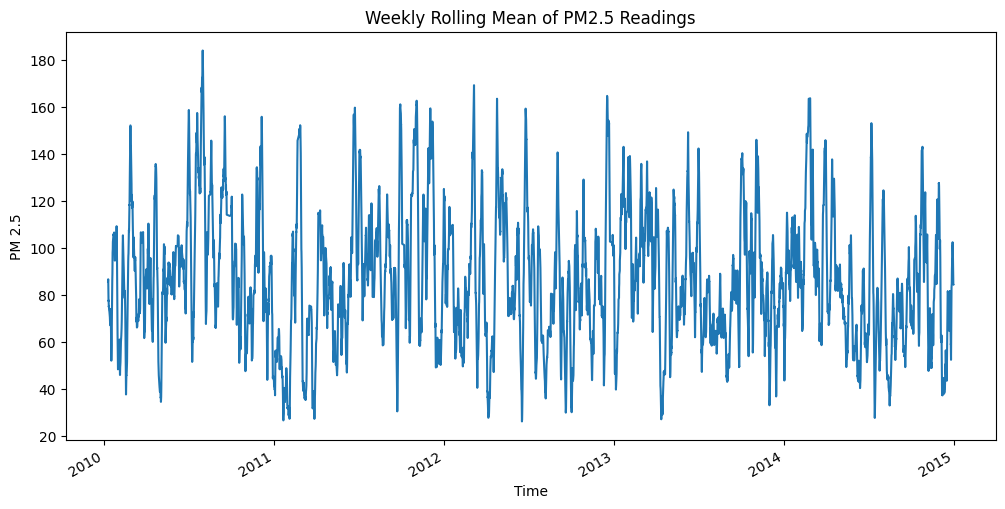

In [22]:
# plot the weekly rolling mean
fig, ax = plt.subplots(figsize=(12, 6))
df_new["pm2.5"].rolling(168).mean().plot(ax=ax, title='Weekly Rolling Mean of PM2.5 Readings', xlabel='Time', ylabel='PM 2.5');

In [24]:
# create a column called 'pm_2' that contains the mean "pm2.5" from the previous hour
df_new["pm_2"] = df_new["pm2.5"].shift(1)
df_new = df_new[["pm2.5", "pm_2"]]
df_new.head()

C:\Users\User\AppData\Local\Temp\ipykernel_18852\3108507534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["pm_2"] = df_new["pm2.5"].shift(1)


,pm2.5,pm_2
datetime,,
2010-01-02 00:00:00+08:00,129.0,NaN
2010-01-02 01:00:00+08:00,148.0,129.0
2010-01-02 02:00:00+08:00,159.0,148.0
2010-01-02 03:00:00+08:00,181.0,159.0
2010-01-02 04:00:00+08:00,138.0,181.0


In [25]:
# drop the bull values
df_new.dropna(inplace=True)

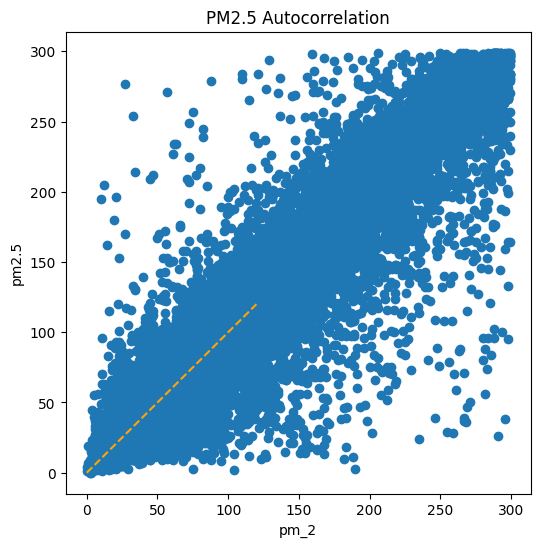

In [27]:
# plot the scatter plot for the colleration
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=df_new["pm_2"], y=df_new["pm2.5"])
ax.plot([0,120], [0,120], linestyle="--", color="orange")
plt.xlabel("pm_2")
plt.ylabel("pm2.5")
plt.title("PM2.5 Autocorrelation");

In [ ]:
# # Drop the other columns excepts the target columns
# df_new = df_new.drop(columns=[col for col in df_new.columns if col not in ['pm_2']])

### Split the datafame into feature matrix "X" and the target vector "y". the target will remain  "pm_2"

### Scale the Data

In [29]:
# create a new dataframe
df_lstm = df_new[["pm_2"]]

In [30]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
scaled_data = scalar.fit_transform(df_lstm)

In [31]:

# Create sequences for LSTM
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 24  # use 24 hours to predict the next hour
X, y = create_sequences(scaled_data, TIME_STEPS)

- Split X and y into training and test sets. The first 80% of the data should be in your training set. The remaining 20% should be in the test set.
- THe spliting will not be the regular split using sklearn


In [32]:
# Train and Test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### Build Model

-  starting with a baseline model so as we can properly evaluate our model
- calculate the summary statistics as well

In [33]:
y_mean = y_train.mean()
y_pred_baseline = np.full_like(y_train, y_mean)

# Ensure both arrays are flattened to 1D
mae_baseline = np.mean(np.abs(y_train.flatten() - y_pred_baseline.flatten()))

print("Mean pm_2 reading:", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean pm_2 reading: 0.29
Baseline MAE: 0.19


### Iterate

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stoppings
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience=5,
    restore_best_weights=True
)

In [35]:

# instantiate the LSTM model named model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# compile the model
model.compile(optimizer="adam", loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

c:\Users\User\anaconda3\envs\itc-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0307 - val_loss: 0.0068
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━

### Evaluate the Model

In [36]:
from sklearn.metrics import mean_absolute_error

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

training_mae = mean_absolute_error(y_train.ravel(), y_train_pred.ravel())
test_mae = mean_absolute_error(y_test.ravel(), y_test_pred.ravel())

print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

999/999 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Training MAE: 0.04
Test MAE: 0.04


In [37]:
# Flatten arrays to 1D for easier comparison and Dataframe creation
df_pred_test = pd.DataFrame({
    "y_test": y_test.ravel(),
    "y_pred": y_test_pred.ravel()
})

df_pred_test.head(10)

,y_test,y_pred
0,0.197324,0.190384
1,0.187291,0.208735
2,0.193980,0.194265
3,0.220736,0.200155
4,0.244147,0.228866
5,0.277592,0.252926
6,0.270903,0.287920
7,0.304348,0.277074
8,0.347826,0.313356
9,0.294314,0.360089


- Create a time series line plot for the values in test_predictions using plotly express. Be sure that the y-axis is properly labeled as "pm_2"

### Once you run this code, it opens your default browser to view the line plot

In [38]:
# Create a line plot using plotly express
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'browser'

fig = px.line(df_pred_test.reset_index().melt(id_vars="index", value_vars=["y_test", "y_pred"]),
              x="index", y="value", color="variable",
              labels={"value": "PM2.5", "index": "Time"},
              title="Actual vs Predicted PM2.5 Readings")
fig.show()

### Save the model

In [40]:
# Save the trained model
model.save("pm25_lstm_model.keras")

### Perform a forcast using the model for the next ! week

In [46]:
# Predict the next month (e.g., 31 days * 24 hours = 744 hours)
future_steps = 168  # adjust as needed

# Start with the last available sequence from data
last_sequence = scaled_data[-TIME_STEPS:].reshape(1, TIME_STEPS, 1)
future_preds = []

for _ in range(future_steps):
    next_pred = model.predict(last_sequence, verbose=0)  # Suppress prediction output
    future_preds.append(next_pred[0, 0])
    
    # Correct reshaping to 3D (1, 1, 1)
    next_pred_reshaped = next_pred.reshape(1, 1, 1)
    
    # Append new prediction and remove the oldest time step
    last_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred_reshaped], axis=1)

# Inverse transform to get predictions in original scale
future_preds_unscaled = scalar.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Create a datetime index for the future predictions
last_datetime = df_lstm.index[-1]
future_index = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=future_steps, freq='H', tz=last_datetime.tz)

# Create a DataFrame for future predictions
df_future = pd.DataFrame({'pm2.5_pred': future_preds_unscaled.ravel()}, index=future_index)

print(df_future.head())

                           pm2.5_pred
2015-01-01 00:00:00+08:00    9.501220
2015-01-01 01:00:00+08:00   11.103686
2015-01-01 02:00:00+08:00   12.823088
2015-01-01 03:00:00+08:00   14.618581
2015-01-01 04:00:00+08:00   16.454889


C:\Users\User\AppData\Local\Temp\ipykernel_18852\2428079783.py:23: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



- Check the plot of the new forcast

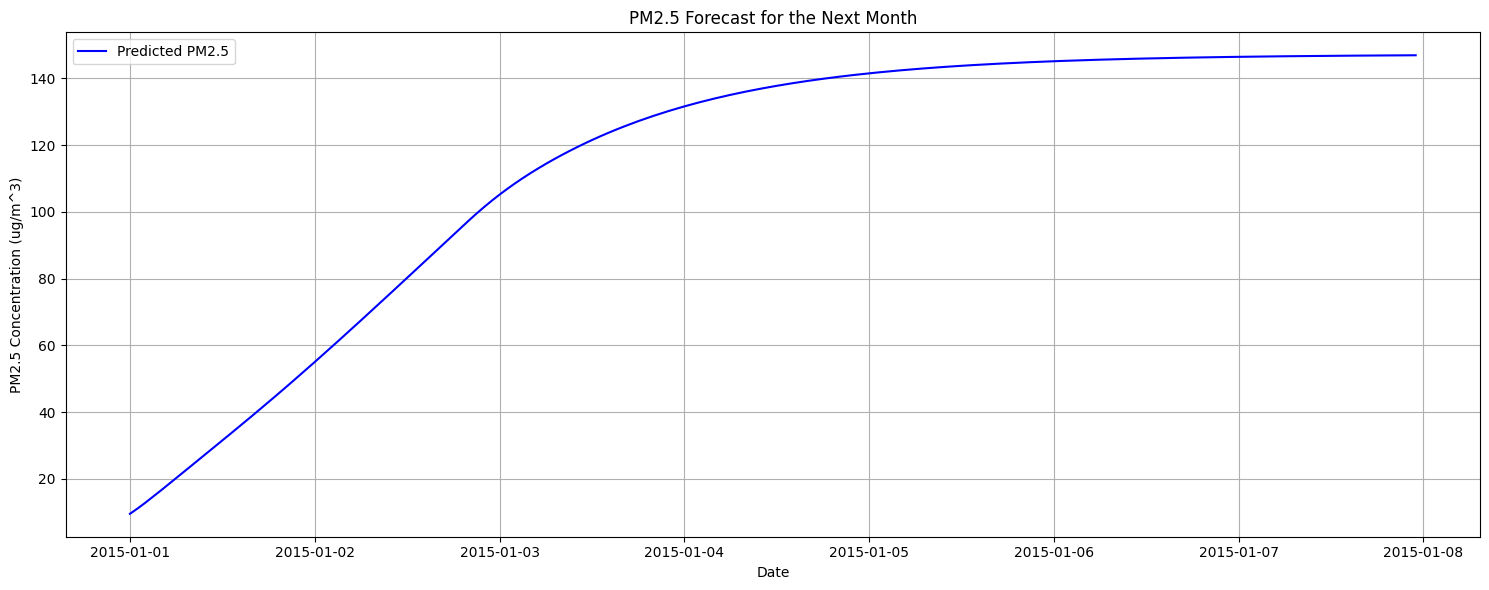

In [47]:
plt.figure(figsize=(15,6))
plt.plot(df_future.index, df_future["pm2.5_pred"], label="Predicted PM2.5", color='blue')
plt.title("PM2.5 Forecast for the Next Month")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration (ug/m^3)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

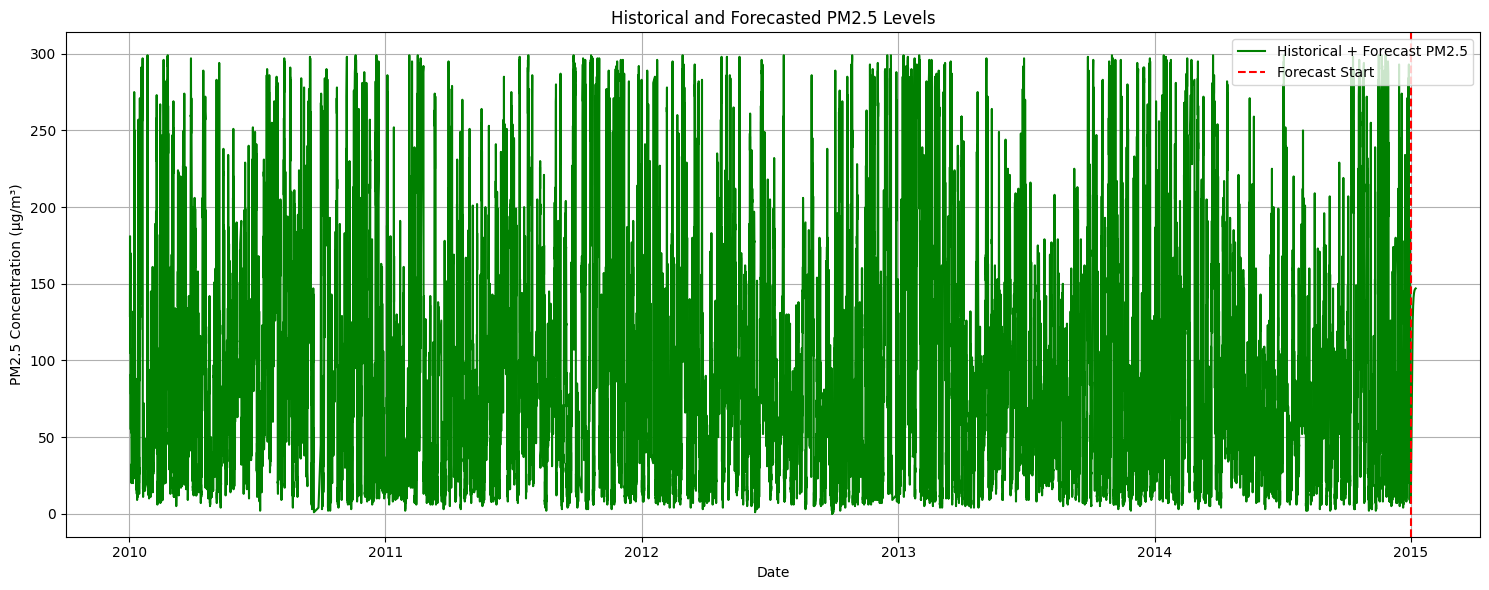

In [48]:
# Merge historical and future forecasts
combined_df = pd.concat([df_lstm[['pm_2']], df_future.rename(columns={"pm2.5_pred": "pm_2"})])

plt.figure(figsize=(15, 6))
plt.plot(combined_df.index, combined_df['pm_2'], label='Historical + Forecast PM2.5', color='green')
plt.axvline(x=df_lstm.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title("Historical and Forecasted PM2.5 Levels")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

This project successfully applied a deep learning approach to time series forecasting for predicting PM2.5 air pollution levels in Beijing. By leveraging historical environmental data, we developed a Long Short-Term Memory (LSTM) neural network that effectively captured temporal dependencies in hourly pollution readings.

Key preprocessing steps—such as handling missing data, creating lag features, resampling, and normalizing the data—ensured that the model was trained on a clean and well-structured dataset. We adhered to time-aware train-test splitting to preserve chronological order and implemented early stopping to prevent overfitting.

The final model achieved a **Mean Absolute Error (MAE) of 0.04**, with visualizations confirming strong alignment between actual and predicted PM2.5 levels. The interactive line plot further validated the model’s capability to track pollution trends accurately.

---

### Highlights:
- Robust preprocessing pipeline including lag features and rolling averages.
- Time series-specific architecture with LSTM and early stopping.
- Quantitative evaluation using MAE and MSE.
- Qualitative assessment via prediction plots.

---

### Final Thoughts

This forecasting model demonstrates high potential for real-world applications such as pollution monitoring systems, environmental policy planning, and public health alerts. With periodic retraining and integration with live data streams, it can evolve into a valuable tool for proactive air quality management.